# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

Competition - https://www.kaggle.com/c/nlp-getting-started


Importer de données

Deep Learning
  * Word Embedding
  * Recurrent Neural Networks
  * Encoder Decoder
  * Attention is All You Need

* Conclusion


## Importer de données 

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import os
import io
import json
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'2.6.0'

In [2]:
import spacy
#!python -m spacy download en_core_web_sm -q
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


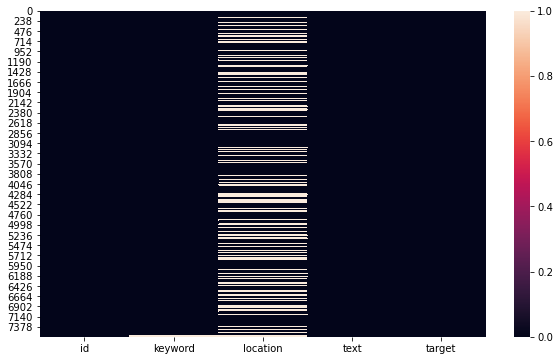

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull())
plt.show()

In [5]:
train1 = train["target"].value_counts(normalize=True)
train1 = train1.mul(100)
train1 = train1.rename("percent").reset_index()
train1.head()

,index,percent
0,0,57.034021
1,1,42.965979


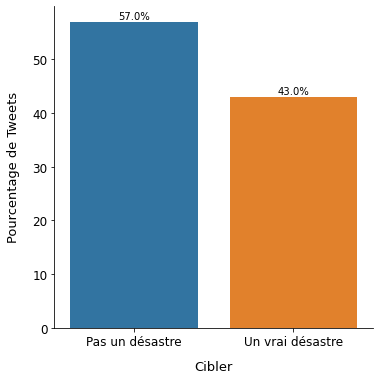

In [6]:
g = sns.catplot(data=train1, x="index", y="percent", kind = "bar")
g.set_xticklabels(["Pas un désastre", "Un vrai désastre"])
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() + 0.3
    txt_y = p.get_height()+0.5
    g.ax.text(txt_x,txt_y,txt)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Cibler",labelpad = 12, fontsize = 13)
plt.ylabel("Pourcentage de Tweets",labelpad = 12, fontsize = 13)
plt.show()

## Word Embedding

If we used traditional DNNs, then we would typically have to encode our input text into a vector of fixed length using techniques like BOW, Word2Vec, etc.

https://www.kaggle.com/colinmorris/embedding-layers

https://gdcoder.com/what-is-an-embedding-layer/

https://towardsdatascience.com/mastering-word-embeddings-in-10-minutes-with-tensorflow-41e25da6aa54

can only be used as the first layer in a model

input dimension has to be equal to the number of unique words, usually if zero maps to a word, one can leave input_dim=len(vocabularly) otherwise input_dim=len(vocabularly)+1

### Embedding

In [7]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train = train[["text", "target"]]
train.head(2)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1


In [8]:
train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
train.head(2)

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada


In [9]:
weight = dict(1/(train["target"].value_counts())/(sum(1/train["target"].value_counts()))*5)
weight

{0: 2.1482989623013267, 1: 2.8517010376986733}

In [10]:
tokenizer_text = tf.keras.preprocessing.text.Tokenizer(num_words=300,
                                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                        lower=True, split=' ', char_level=False, oov_token=None,
                                                        document_count=0)

In [11]:
tokenizer_text.fit_on_texts(train["text_clean"])
train["text_encoded"] = tokenizer_text.texts_to_sequences(train["text_clean"])
train["len_text"] = train["text_encoded"].apply(lambda x: len(x))
train = train[train["len_text"]!=0]
train.head(2)

,text,target,text_clean,text_encoded,len_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive,[174],1
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[119, 4, 162]",3


In [12]:
len(tokenizer_text.word_index)

20283

Padding est une forme particulière de masquage dans lequel les étapes sont masquées au début ou à la fin d'une séquence. Le bourrage vient de la nécessité d'encoder les données de séquence en lots contigus : pour que toutes les séquences d'un lot correspondent à une longueur standard donnée, il est nécessaire de bourrer ou de tronquer certaines séquences.

pad either before or after each sequence. 

In [13]:
#Padding means adding values before and after Tensor values.
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train["text_encoded"], padding='post')
train_pad

array([[174,   0,   0, ...,   0,   0,   0],
       [119,   4, 162, ...,   0,   0,   0],
       [298, 187, 285, ...,   0,   0,   0],
       ...,
       [  6,   0,   0, ...,   0,   0,   0],
       [ 25,  90,  45, ...,   0,   0,   0],
       [102,  28, 129, ...,   0,   0,   0]])

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train["target"].values))
train_ds

<TensorSliceDataset shapes: ((13,), ()), types: (tf.int32, tf.int64)>

In [15]:
TAKE_SIZE = int(0.8*train.shape[0])

train_data = train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

val_data = train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(32)

In [16]:
for text, target in train_data.take(1):
  print(text, target)

tf.Tensor(
[[ 21  12   0   0   0   0   0   0   0   0   0   0   0]
 [155   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 49 134  99 173   0   0   0   0   0   0   0   0   0]
 [  1 231 289 135   0   0   0   0   0   0   0   0   0]
 [  4 153   0   0   0   0   0   0   0   0   0   0   0]
 [143 195 135 206   0   0   0   0   0   0   0   0   0]
 [  6  78  80   0   0   0   0   0   0   0   0   0   0]
 [193  70 265 254  59   0   0   0   0   0   0   0   0]
 [284   3   1   0   0   0   0   0   0   0   0   0   0]
 [ 26 232  47 239   0   0   0   0   0   0   0   0   0]
 [ 62   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 76   5  31  76 241   1   0   0   0   0   0   0   0]
 [ 26   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 10  57  93   0   0   0   0   0   0   0   0   0   0]
 [  2 248 114  28   0   0   0   0   0   0   0   0   0]
 [ 42   0   0   0   0   0   0   0   0   0   0   0   0]
 [216   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 27  27 150  89   0   0   0   0   0   0   0   0   0]

In [17]:
text.shape

TensorShape([32, 13])

In [18]:
vocab_size = len(tokenizer_text.word_index)
vocab_size

20283

In [19]:
model_embedding = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=[text.shape[1],],
                                            name="embedding"),
                #tf.keras.layers.Conv1D(140, 3, activation='relu', strides=1),

                # Gobal average pooling
                tf.keras.layers.GlobalAveragePooling1D(),

                # Couche Dense classique
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),

                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])
model_embedding.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 64)            1298176   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,300,801
Trainable params: 1,300,801
Non-trainable params: 0
_________________________________________________________________


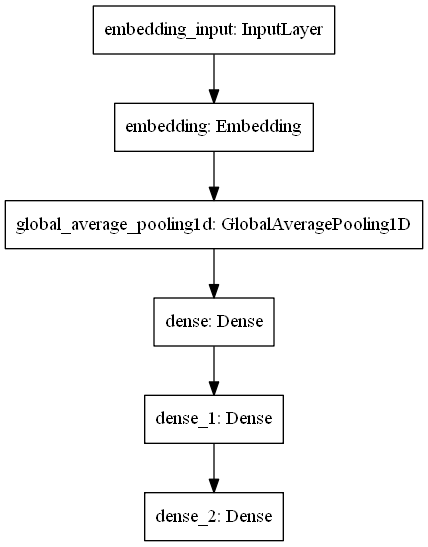

In [20]:
tf.keras.utils.plot_model(
    model_embedding, show_shapes=False, show_layer_names=True
)

In [21]:
model_embedding.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [22]:
history_embedding = model_embedding.fit(train_data, 
                                        epochs=20, 
                                        validation_data=val_data,
                                        class_weight=weight)

Epoch 1/20
178/178 [==============================] - 3s 15ms/step - loss: 1.6640 - binary_accuracy: 0.6341 - val_loss: 0.6373 - val_binary_accuracy: 0.7707
Epoch 2/20
178/178 [==============================] - 3s 14ms/step - loss: 1.3564 - binary_accuracy: 0.7586 - val_loss: 0.5065 - val_binary_accuracy: 0.7496
Epoch 3/20
178/178 [==============================] - 3s 14ms/step - loss: 1.1966 - binary_accuracy: 0.7758 - val_loss: 0.5112 - val_binary_accuracy: 0.7222
Epoch 4/20
178/178 [==============================] - 3s 14ms/step - loss: 1.1682 - binary_accuracy: 0.7804 - val_loss: 0.5531 - val_binary_accuracy: 0.6948
Epoch 5/20
178/178 [==============================] - 2s 14ms/step - loss: 1.1614 - binary_accuracy: 0.7790 - val_loss: 0.5318 - val_binary_accuracy: 0.7096
Epoch 6/20
178/178 [==============================] - 3s 14ms/step - loss: 1.1483 - binary_accuracy: 0.7851 - val_loss: 0.5380 - val_binary_accuracy: 0.7060
Epoch 7/20
178/178 [==============================] - 2s 1

In [23]:
history_embedding.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

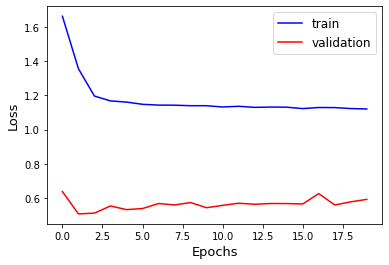

In [24]:
# Visualization of the training process on the loss function 
plt.plot(history_embedding.history["loss"], color="b", label='train')
plt.plot(history_embedding.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

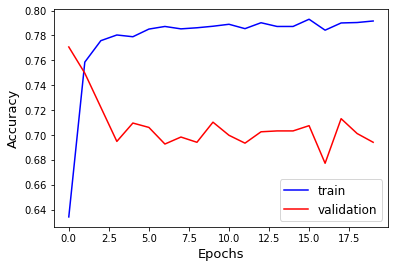

In [25]:
# Visualization of accuracy training 
plt.plot(history_embedding.history["binary_accuracy"], color="b", label='train')
plt.plot(history_embedding.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

In [26]:
model_embedding.save("embedding.h5")
json.dump(model_embedding.history.history, open("embedding.json", 'w'))

In [27]:
embedding = json.load(open("embedding.json", 'r'))

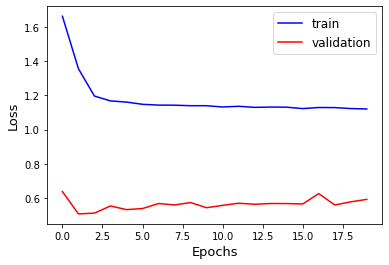

In [28]:
plt.plot(embedding["loss"], color="b", label='train')
plt.plot(embedding["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize = 12)
plt.show()

In [29]:
url_test = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/test.csv"
test = pd.read_csv(url_test)
test = test[["text"]]
test.head(2)

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, stay safe everyone."


In [30]:
test["text_clean"] = test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
test["text_clean"] = test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
test["text_clean"] = test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
test.head(2)

,text,text_clean
0,Just happened a terrible car crash,happen terrible car crash
1,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe


In [31]:
tokenizer_text.fit_on_texts(test["text_clean"])
test["text_encoded"] = tokenizer_text.texts_to_sequences(test["text_clean"])
test.head(2)

,text,text_clean,text_encoded
0,Just happened a terrible car crash,happen terrible car crash,"[149, 47, 16]"
1,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe,"[101, 181, 133]"


In [32]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test["text_encoded"], padding='post')
test_pad.shape

(3263, 14)

In [33]:
prediction = model_embedding.predict(test_pad)
prediction.shape

Model was constructed with shape (None, 13) for input KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 14).


(3263, 1)

In [34]:
url_submission = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/sample_submission.csv"
submission = pd.read_csv(url_submission)
submission["target"] = prediction
submission["target"] = submission["target"].apply(lambda x : 0 if x <= 0.5 else 1)
submission.head(5)

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,0


## Recurrent Neural Networks

### SimpleRNN

In [35]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train = train[["text", "target"]]

train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

weight = dict(1/(train["target"].value_counts())/(sum(1/train["target"].value_counts()))*5)

In [36]:
tokenizer_text = tf.keras.preprocessing.text.Tokenizer(num_words=300,
                                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                        lower=True, split=' ', char_level=False, oov_token=None,
                                                        document_count=0)

tokenizer_text.fit_on_texts(train["text_clean"])
train["text_encoded"] = tokenizer_text.texts_to_sequences(train["text_clean"])
train["len_text"] = train["text_encoded"].apply(lambda x: len(x))
train = train[train["len_text"]!=0]
train.head(2)

,text,target,text_clean,text_encoded,len_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive,[174],1
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[119, 4, 162]",3


In [37]:
len(tokenizer_text.word_index)

20283

In [38]:
#Padding means adding values before and after Tensor values.
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train["text_encoded"], padding='post')
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train["target"].values))

In [39]:
TAKE_SIZE = int(0.8*train.shape[0])

train_data = train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

val_data = train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(32)

In [40]:
for text, target in train_data.take(1):
  print(text, target)

tf.Tensor(
[[  1  60   0   0   0   0   0   0   0   0   0   0   0]
 [164  26  60 157   0   0   0   0   0   0   0   0   0]
 [149   0   0   0   0   0   0   0   0   0   0   0   0]
 [121   0   0   0   0   0   0   0   0   0   0   0   0]
 [156 190   0   0   0   0   0   0   0   0   0   0   0]
 [136  80   0   0   0   0   0   0   0   0   0   0   0]
 [101  64 295  12 177 258   0   0   0   0   0   0   0]
 [  3 126  36   0   0   0   0   0   0   0   0   0   0]
 [120 279 260  48 290  60   0   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 88   1  43   0   0   0   0   0   0   0   0   0   0]
 [  5  89  28 259  49   0   0   0   0   0   0   0   0]
 [ 22   0   0   0   0   0   0   0   0   0   0   0   0]
 [195 299   0   0   0   0   0   0   0   0   0   0   0]
 [179   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 64 157   0   0   0   0   0   0   0   0   0   0   0]
 [ 21  21  25 170  13 179 250  21   0   0   0   0   0]
 [ 59  50  78  90   0   0   0   0   0   0   0   0   0]

In [41]:
vocab_size = len(tokenizer_text.word_index)
vocab_size

20283

In [42]:
model_srnn = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=[text.shape[1],],
                                            name="embedding"),
                
                tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                tf.keras.layers.SimpleRNN(units=32, return_sequences=True),

                # Couche Dense classique
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),

                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])
model_srnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 64)            1298176   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 13, 64)            8256      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 13, 32)            3104      
_________________________________________________________________
dense_3 (Dense)              (None, 13, 32)            1056      
_________________________________________________________________
dense_4 (Dense)              (None, 13, 16)            528       
_________________________________________________________________
dense_5 (Dense)              (None, 13, 1)             17        
Total params: 1,311,137
Trainable params: 1,311,137
Non-trainable params: 0
____________________________________________

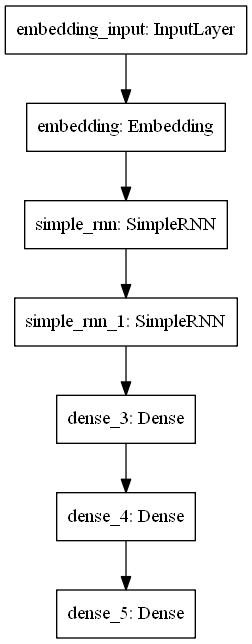

In [43]:
tf.keras.utils.plot_model(
    model_srnn, show_shapes=False, show_layer_names=True
)

In [44]:
model_srnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [45]:
history_srnn = model_srnn.fit(train_data, epochs=20, validation_data=val_data, class_weight=weight)

Epoch 1/20
178/178 [==============================] - 5s 19ms/step - loss: 1.5058 - binary_accuracy: 0.6742 - val_loss: 0.5660 - val_binary_accuracy: 0.7085
Epoch 2/20
178/178 [==============================] - 3s 16ms/step - loss: 1.2818 - binary_accuracy: 0.7645 - val_loss: 0.5530 - val_binary_accuracy: 0.7111
Epoch 3/20
178/178 [==============================] - 3s 17ms/step - loss: 1.2301 - binary_accuracy: 0.7758 - val_loss: 0.5697 - val_binary_accuracy: 0.7027
Epoch 4/20
178/178 [==============================] - 3s 16ms/step - loss: 1.2026 - binary_accuracy: 0.7834 - val_loss: 0.5898 - val_binary_accuracy: 0.6875
Epoch 5/20
178/178 [==============================] - 3s 17ms/step - loss: 1.1924 - binary_accuracy: 0.7804 - val_loss: 0.5841 - val_binary_accuracy: 0.6916
Epoch 6/20
178/178 [==============================] - 3s 17ms/step - loss: 1.1654 - binary_accuracy: 0.7850 - val_loss: 0.6359 - val_binary_accuracy: 0.6828
Epoch 7/20
178/178 [==============================] - 3s 1

In [46]:
history_srnn.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

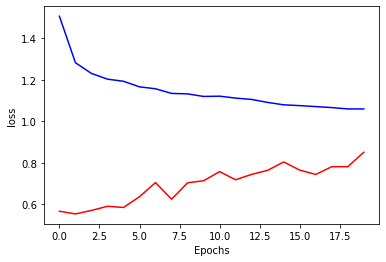

In [47]:
# Visualization of the training process on the loss function 
plt.plot(history_srnn.history["loss"], color="b")
plt.plot(history_srnn.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

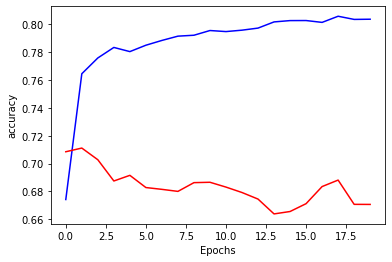

In [48]:
# Visualization of accuracy training 
plt.plot(history_srnn.history["binary_accuracy"], color="b")
plt.plot(history_srnn.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [49]:
model_srnn.save("srnn.h5")
json.dump(model_srnn.history.history, open("srnn.json", 'w'))

srnn = json.load(open("srnn.json", 'r'))

In [50]:
url_test = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/test.csv"
test = pd.read_csv(url_test)
test = test[["text"]]

test["text_clean"] = test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
test["text_clean"] = test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
test["text_clean"] = test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

tokenizer_text.fit_on_texts(test["text_clean"])
test["text_encoded"] = tokenizer_text.texts_to_sequences(test["text_clean"])
test.head()

,text,text_clean,text_encoded
0,Just happened a terrible car crash,happen terrible car crash,"[149, 47, 16]"
1,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe,"[101, 181, 133]"
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese flee street save,"[94, 3, 99]"
3,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,"[297, 258, 75]"
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,[11]


In [51]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test["text_encoded"], padding='post')
test_pad.shape

(3263, 14)

In [52]:
prediction = model_srnn.predict(test_pad)
prediction.shape

Model was constructed with shape (None, 13) for input KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 14).


(3263, 14, 1)

In [53]:
prediction = prediction.reshape(3263, 14)
prediction.shape

(3263, 14)

In [54]:
url_submission = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/sample_submission.csv"
submission = pd.read_csv(url_submission)
submission["target"] = prediction
submission["target"] = submission["target"].apply(lambda x : 0 if x <= 0.5 else 1)
submission.head(5)

,id,target
0,0,0
1,2,1
2,3,0
3,9,1
4,11,0


### Gru

In [55]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train = train[["text", "target"]]

train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

weight = dict(1/(train["target"].value_counts())/(sum(1/train["target"].value_counts()))*5)

In [56]:
tokenizer_text = tf.keras.preprocessing.text.Tokenizer(num_words=300,
                                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                        lower=True, split=' ', char_level=False, oov_token=None,
                                                        document_count=0)

tokenizer_text.fit_on_texts(train["text_clean"])
train["text_encoded"] = tokenizer_text.texts_to_sequences(train["text_clean"])
train["len_text"] = train["text_encoded"].apply(lambda x: len(x))
train = train[train["len_text"]!=0]

In [57]:
len(tokenizer_text.word_index)

20283

In [58]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train["text_encoded"], padding='post')
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train["target"].values))

In [59]:
TAKE_SIZE = int(0.8*train.shape[0])

train_data = train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

val_data = train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(32)

In [60]:
for text, target in train_data.take(1):
  print(text, target)

tf.Tensor(
[[ 25 121 172   0   0   0   0   0   0   0   0   0   0]
 [181   3 207 230 211   0   0   0   0   0   0   0   0]
 [ 70  90   0   0   0   0   0   0   0   0   0   0   0]
 [214  14   0   0   0   0   0   0   0   0   0   0   0]
 [ 29  48 266 180  65   0   0   0   0   0   0   0   0]
 [  9 110 218 192   0   0   0   0   0   0   0   0   0]
 [ 20 100   0   0   0   0   0   0   0   0   0   0   0]
 [ 83  69   0   0   0   0   0   0   0   0   0   0   0]
 [  7 116   0   0   0   0   0   0   0   0   0   0   0]
 [ 62   2 296 171  81 171   2 288 228  35  40   0   0]
 [179   0   0   0   0   0   0   0   0   0   0   0   0]
 [242 131 102   8  45   0   0   0   0   0   0   0   0]
 [229  94  85   0   0   0   0   0   0   0   0   0   0]
 [181  17  32  44   0   0   0   0   0   0   0   0   0]
 [ 67 104  56  16   0   0   0   0   0   0   0   0   0]
 [192  50 114 172   0   0   0   0   0   0   0   0   0]
 [ 81 252   0   0   0   0   0   0   0   0   0   0   0]
 [ 32  85   4   0   0   0   0   0   0   0   0   0   0]

In [61]:
vocab_size = len(tokenizer_text.word_index)
vocab_size

20283

In [62]:
model_gru = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=[text.shape[1],],
                                            name="embedding"),
                
                tf.keras.layers.GRU(units=64, return_sequences=True),
                tf.keras.layers.GRU(units=32, return_sequences=True),

                # Couche Dense classique
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),

                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 64)            1298176   
_________________________________________________________________
gru (GRU)                    (None, 13, 64)            24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 13, 32)            9408      
_________________________________________________________________
dense_6 (Dense)              (None, 13, 32)            1056      
_________________________________________________________________
dense_7 (Dense)              (None, 13, 16)            528       
_________________________________________________________________
dense_8 (Dense)              (None, 13, 1)             17        
Total params: 1,334,145
Trainable params: 1,334,145
Non-trainable params: 0
____________________________________________

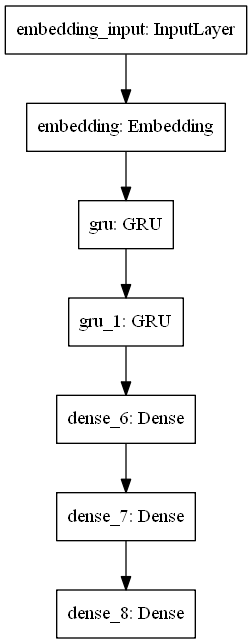

In [63]:
tf.keras.utils.plot_model(
    model_gru, show_shapes=False, show_layer_names=True
)

In [64]:
model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [65]:
history_gru = model_gru.fit(train_data, epochs=20, validation_data=val_data, class_weight=weight)

Epoch 1/20
178/178 [==============================] - 8s 27ms/step - loss: 1.5447 - binary_accuracy: 0.6101 - val_loss: 0.5511 - val_binary_accuracy: 0.7172
Epoch 2/20
178/178 [==============================] - 4s 23ms/step - loss: 1.2696 - binary_accuracy: 0.7595 - val_loss: 0.5400 - val_binary_accuracy: 0.7235
Epoch 3/20
178/178 [==============================] - 4s 23ms/step - loss: 1.2247 - binary_accuracy: 0.7710 - val_loss: 0.5467 - val_binary_accuracy: 0.7170
Epoch 4/20
178/178 [==============================] - 4s 24ms/step - loss: 1.2123 - binary_accuracy: 0.7721 - val_loss: 0.5926 - val_binary_accuracy: 0.6904
Epoch 5/20
178/178 [==============================] - 4s 23ms/step - loss: 1.1998 - binary_accuracy: 0.7786 - val_loss: 0.5898 - val_binary_accuracy: 0.6893
Epoch 6/20
178/178 [==============================] - 4s 23ms/step - loss: 1.1926 - binary_accuracy: 0.7803 - val_loss: 0.5811 - val_binary_accuracy: 0.6838
Epoch 7/20
178/178 [==============================] - 4s 2

In [66]:
history_gru.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

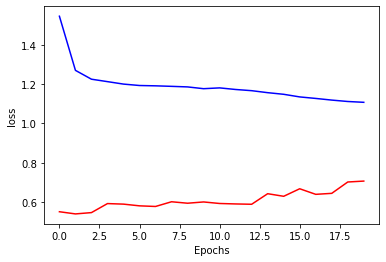

In [67]:
# Visualization of the training process on the loss function 
plt.plot(history_gru.history["loss"], color="b")
plt.plot(history_gru.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

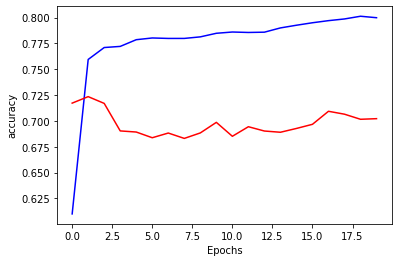

In [68]:
# Visualization of accuracy training 
plt.plot(history_gru.history["binary_accuracy"], color="b")
plt.plot(history_gru.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [69]:
model_gru.save("gru.h5")
json.dump(model_gru.history.history, open("gru.json", 'w'))

gru = json.load(open("gru.json", 'r'))

In [70]:
url_test = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/test.csv"
test = pd.read_csv(url_test)
test = test[["text"]]

test["text_clean"] = test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
test["text_clean"] = test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
test["text_clean"] = test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

tokenizer_text.fit_on_texts(test["text_clean"])
test["text_encoded"] = tokenizer_text.texts_to_sequences(test["text_clean"])
test.head()

,text,text_clean,text_encoded
0,Just happened a terrible car crash,happen terrible car crash,"[149, 47, 16]"
1,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe,"[101, 181, 133]"
2,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",forest fire spot pond geese flee street save,"[94, 3, 99]"
3,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire,"[297, 258, 75]"
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,[11]


In [71]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test["text_encoded"], padding='post')
test_pad

array([[149,  47,  16, ...,   0,   0,   0],
       [101, 181, 133, ...,   0,   0,   0],
       [ 94,   3,  99, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [166, 208,   0, ...,   0,   0,   0],
       [ 15,  63,   0, ...,   0,   0,   0]])

In [72]:
prediction = model_gru.predict(test_pad)
prediction.shape

Model was constructed with shape (None, 13) for input KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 14).


(3263, 14, 1)

In [73]:
prediction = prediction.reshape(3263, 14)
prediction.shape

(3263, 14)

In [74]:
url_submission = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/sample_submission.csv"
submission = pd.read_csv(url_submission)
submission["target"] = prediction
submission["target"] = submission["target"].apply(lambda x : 0 if x <= 0.5 else 1)
submission.head(5)

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0


### LSTM

In [75]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train = train[["text", "target"]]

train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

weight = dict(1/(train["target"].value_counts())/(sum(1/train["target"].value_counts()))*5)

In [76]:
tokenizer_text = tf.keras.preprocessing.text.Tokenizer(num_words=300,
                                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                        lower=True, split=' ', char_level=False, oov_token=None,
                                                        document_count=0)

tokenizer_text.fit_on_texts(train["text_clean"])
train["text_encoded"] = tokenizer_text.texts_to_sequences(train["text_clean"])
train["len_text"] = train["text_encoded"].apply(lambda x: len(x))
train = train[train["len_text"]!=0]
train.head(2)

,text,target,text_clean,text_encoded,len_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive,[174],1
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[119, 4, 162]",3


In [77]:
len(tokenizer_text.word_index)

20283

In [78]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train["text_encoded"], padding='post')
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train["target"].values))

In [79]:
TAKE_SIZE = int(0.8*train.shape[0])

train_data = train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(32)

val_data = train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(32)

In [80]:
for text, target in train_data.take(1):
  print(text, target)

tf.Tensor(
[[  3  89   0   0   0   0   0   0   0   0   0   0   0]
 [ 61   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 27 111 161 237   0   0   0   0   0   0   0   0   0]
 [ 37 271  98  41  98 244  76  37   0   0   0   0   0]
 [252   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 51 250 152   0   0   0   0   0   0   0   0   0   0]
 [268 153   0   0   0   0   0   0   0   0   0   0   0]
 [  2  75   0   0   0   0   0   0   0   0   0   0   0]
 [ 21  13  97   5  26  41   0   0   0   0   0   0   0]
 [233   0   0   0   0   0   0   0   0   0   0   0   0]
 [150  20 295   1   0   0   0   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 59   0   0   0   0   0   0   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 29  13   0   0   0   0   0   0   0   0   0   0   0]
 [137 292 245   0   0   0   0   0   0   0   0   0   0]
 [ 87  61  48 118  31  83  26   0   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0   0   0   0]

In [81]:
vocab_size = len(tokenizer_text.word_index)
vocab_size

20283

In [82]:
model_lstm = tf.keras.Sequential([
                # Couche d'Input Word Embedding           
                tf.keras.layers.Embedding(input_dim=vocab_size+1, output_dim=64, input_shape=[text.shape[1],],
                                            name="embedding"),
                
                tf.keras.layers.LSTM(units=64, return_sequences=True),
                tf.keras.layers.LSTM(units=32, return_sequences=True),

                # Couche Dense classique
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),                

                # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                tf.keras.layers.Dense(1, activation="sigmoid")
])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 64)            1298176   
_________________________________________________________________
lstm (LSTM)                  (None, 13, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 32)            12416     
_________________________________________________________________
dense_9 (Dense)              (None, 13, 32)            1056      
_________________________________________________________________
dense_10 (Dense)             (None, 13, 16)            528       
_________________________________________________________________
dense_11 (Dense)             (None, 13, 1)             17        
Total params: 1,345,217
Trainable params: 1,345,217
Non-trainable params: 0
____________________________________________

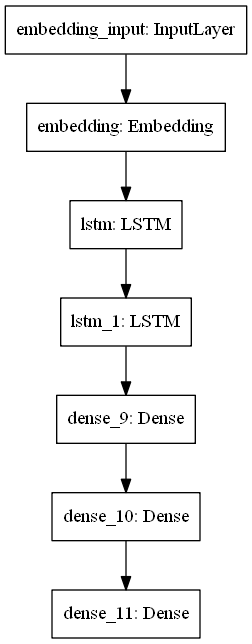

In [83]:
tf.keras.utils.plot_model(
    model_lstm, show_shapes=False, show_layer_names=True
)

In [84]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                            loss=tf.keras.losses.BinaryCrossentropy(),
                            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [85]:
history_lstm = model_lstm.fit(train_data, epochs=20, validation_data=val_data, class_weight=weight)

Epoch 1/20
178/178 [==============================] - 8s 26ms/step - loss: 1.5271 - binary_accuracy: 0.6809 - val_loss: 0.5587 - val_binary_accuracy: 0.7241
Epoch 2/20
178/178 [==============================] - 4s 22ms/step - loss: 1.2865 - binary_accuracy: 0.7679 - val_loss: 0.5486 - val_binary_accuracy: 0.7105
Epoch 3/20
178/178 [==============================] - 4s 22ms/step - loss: 1.2370 - binary_accuracy: 0.7741 - val_loss: 0.5533 - val_binary_accuracy: 0.7038
Epoch 4/20
178/178 [==============================] - 4s 22ms/step - loss: 1.2202 - binary_accuracy: 0.7764 - val_loss: 0.5885 - val_binary_accuracy: 0.6866
Epoch 5/20
178/178 [==============================] - 4s 22ms/step - loss: 1.2050 - binary_accuracy: 0.7767 - val_loss: 0.5634 - val_binary_accuracy: 0.7005
Epoch 6/20
178/178 [==============================] - 4s 22ms/step - loss: 1.1933 - binary_accuracy: 0.7815 - val_loss: 0.5929 - val_binary_accuracy: 0.6857
Epoch 7/20
178/178 [==============================] - 4s 2

In [86]:
history_lstm.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

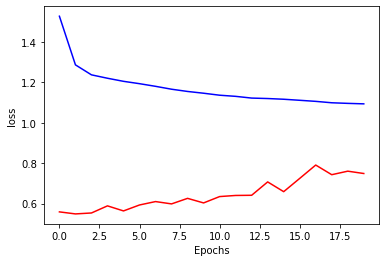

In [87]:
# Visualization of the training process on the loss function 
plt.plot(history_lstm.history["loss"], color="b")
plt.plot(history_lstm.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

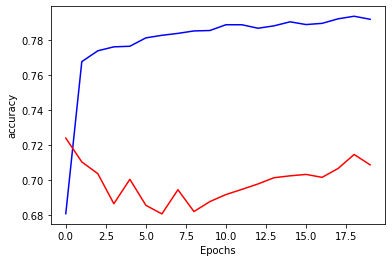

In [88]:
# Visualization of accuracy training 
plt.plot(history_lstm.history["binary_accuracy"], color="b")
plt.plot(history_lstm.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [89]:
model_lstm.save("lstm.h5")
json.dump(model_lstm.history.history, open("lstm.json", 'w'))

In [90]:
lstm = json.load(open("lstm.json", 'r'))

In [91]:
url_test = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/test.csv"
test = pd.read_csv(url_test)
test = test[["text"]]

test["text_clean"] = test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
test["text_clean"] = test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
test["text_clean"] = test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

tokenizer_text.fit_on_texts(test["text_clean"])
test["text_encoded"] = tokenizer_text.texts_to_sequences(test["text_clean"])
test.head(2)

,text,text_clean,text_encoded
0,Just happened a terrible car crash,happen terrible car crash,"[149, 47, 16]"
1,"Heard about #earthquake is different cities, stay safe everyone.",hear earthquake different city stay safe,"[101, 181, 133]"


In [92]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test["text_encoded"], padding='post')
test_pad

array([[149,  47,  16, ...,   0,   0,   0],
       [101, 181, 133, ...,   0,   0,   0],
       [ 94,   3,  99, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [166, 208,   0, ...,   0,   0,   0],
       [ 15,  63,   0, ...,   0,   0,   0]])

In [93]:
prediction = model_lstm.predict(test_pad)
prediction = prediction.reshape(3263, 14)
prediction.shape

Model was constructed with shape (None, 13) for input KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 14).


(3263, 14)

In [94]:
url_submission = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/sample_submission.csv"
submission = pd.read_csv(url_submission)
submission["target"] = prediction
submission["target"] = submission["target"].apply(lambda x : 0 if x <= 0.5 else 1)
submission.head(5)

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0


## Encoder decoder

Here our input is a sequence of words and output is a single number between 0 and 1.

* Encoder: The encoder processes each token in the input-sequence. It tries to cram all the information about the input-sequence into a vector of fixed length i.e. the ‘context vector’. After going through all the tokens, the encoder passes this vector onto the decoder.
* Context vector: The vector is built in such a way that it's expected to encapsulate the whole meaning of the input-sequence and help the decoder make accurate predictions. We will see later that this is the final internal states of our encoder block.
* Decoder: The decoder reads the context vector and tries to predict the target-sequence token by token.

* The input-sequence in both the decoder and the encoder is passed through an embedding layer to reduce the dimensions of the input word vectors because in practice, the one-hot-encoded vectors can be very large and the embedded vectors are a much better representation of words.

In [95]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train = train[["text", "target"]]
train["target"] = train["target"].astype(str)
train.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [96]:
train["padded_target"] = train.iloc[:,1].apply(lambda x: "<start> "+x)
train.head(5)

,text,target,padded_target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,<start> 1
1,Forest fire near La Ronge Sask. Canada,1,<start> 1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,<start> 1
3,"13,000 people receive #wildfires evacuation orders in California",1,<start> 1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,<start> 1


In [97]:
tokenizer_text = tf.keras.preprocessing.text.Tokenizer(num_words=300,
                                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                        lower=True, split=' ', char_level=False, oov_token=None,
                                                        document_count=0)

#the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept. 
tokenizer_target = tf.keras.preprocessing.text.Tokenizer(num_words=4,
                                                            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                            lower=True, split=' ', char_level=False, oov_token=None,
                                                            document_count=0)

In [98]:
tokenizer_text.fit_on_texts(train["text"])
tokenizer_target.fit_on_texts(train["padded_target"])

In [99]:
train["text_indices"] = tokenizer_text.texts_to_sequences(train["text"])
train["target_indices"] = tokenizer_target.texts_to_sequences(train["target"])
train["padded_target_indices"] = tokenizer_target.texts_to_sequences(train["padded_target"])
train.head(2)

,text,target,padded_target,text_indices,target_indices,padded_target_indices
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,<start> 1,"[119, 24, 4, 8, 21, 263, 138, 89, 40]",[3],"[1, 3]"
1,Forest fire near La Ronge Sask. Canada,1,<start> 1,"[189, 45, 229]",[3],"[1, 3]"


In [100]:
len(tokenizer_text.word_index)

22700

In [101]:
tokenizer_target.word_index

{'start': 1, '0': 2, '1': 3}

In [102]:
len(tokenizer_target.word_index)

3

In [103]:
train["padded_target_indices_clean"] = train["padded_target_indices"].apply(lambda x: x[:-1])
train.head()

,text,target,padded_target,text_indices,target_indices,padded_target_indices,padded_target_indices_clean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,<start> 1,"[119, 24, 4, 8, 21, 263, 138, 89, 40]",[3],"[1, 3]",[1]
1,Forest fire near La Ronge Sask. Canada,1,<start> 1,"[189, 45, 229]",[3],"[1, 3]",[1]
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,<start> 1,"[40, 7, 6, 24, 136, 20, 39, 256, 57, 6, 24]",[3],"[1, 3]",[1]
3,"13,000 people receive #wildfires evacuation orders in California",1,<start> 1,"[59, 256, 6, 96]",[3],"[1, 3]",[1]
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,<start> 1,"[34, 100, 21, 22, 30, 271, 22, 69, 5, 187]",[3],"[1, 3]",[1]


In [104]:
# Use of Keras to create token sequences of the same length
padded_text_indices = tf.keras.preprocessing.sequence.pad_sequences(train["text_indices"], padding="post")
padded_target_indices = tf.keras.preprocessing.sequence.pad_sequences(train["target_indices"], padding="post")
teacher_forcing_target = tf.keras.preprocessing.sequence.pad_sequences(train["padded_target_indices_clean"], padding="post")

In [105]:
padded_text_indices.shape

(7613, 26)

In [106]:
padded_target_indices.shape

(7613, 1)

In [107]:
teacher_forcing_target.shape

(7613, 1)

> train_test_split with sklearn

In [108]:
from sklearn.model_selection import train_test_split
target_train, target_val, text_train, text_val, teacher_train, teacher_val =  train_test_split(padded_target_indices,
                                                                                   padded_text_indices,
                                                                                   teacher_forcing_target,
                                                                                   test_size=0.2)

In [109]:
text_train.shape

(6090, 26)

In [110]:
target_train.shape

(6090, 1)

In [111]:
teacher_train.shape

(6090, 1)

In [112]:
n_lstm = 64
n_embed = 128
text_len = padded_text_indices.shape[1]
target_len = padded_target_indices.shape[1]
vocab_size_text = len(tokenizer_text.word_index)
vocab_size_target = len(tokenizer_target.word_index)

In [113]:
text_len

26

In [114]:
target_len

1

In [115]:
# encorder text
encoder_input = tf.keras.Input(shape=(text_len))
encoder_embed = tf.keras.layers.Embedding(input_dim=vocab_size_text+1, output_dim=n_embed)
encoder_lstm = tf.keras.layers.LSTM(n_lstm, return_state=True)

encoder_embed_ouput = encoder_embed(encoder_input)
encoder_output = encoder_lstm(encoder_embed_ouput)

encoder = tf.keras.Model(inputs = encoder_input, outputs = encoder_output)

In [116]:
encoder(text_train)

[<tf.Tensor: shape=(6090, 64), dtype=float32, numpy=
 array([[ 0.01066365,  0.03389977, -0.02621304, ..., -0.01305587,
         -0.04044696,  0.00361188],
        [ 0.01176159,  0.03601053, -0.02878214, ..., -0.0127019 ,
         -0.04036213,  0.00313721],
        [ 0.01192052,  0.03622124, -0.0291597 , ..., -0.01265279,
         -0.04027905,  0.00308907],
        ...,
        [ 0.01122139,  0.03388819, -0.02612916, ..., -0.01337933,
         -0.04118439,  0.00336571],
        [ 0.009514  ,  0.03214344, -0.02379894, ..., -0.0136982 ,
         -0.04145564,  0.00352858],
        [ 0.00929591,  0.03292777, -0.02443781, ..., -0.01335967,
         -0.04097494,  0.00358718]], dtype=float32)>,
 <tf.Tensor: shape=(6090, 64), dtype=float32, numpy=
 array([[ 0.01066365,  0.03389977, -0.02621304, ..., -0.01305587,
         -0.04044696,  0.00361188],
        [ 0.01176159,  0.03601053, -0.02878214, ..., -0.0127019 ,
         -0.04036213,  0.00313721],
        [ 0.01192052,  0.03622124, -0.0291597 ,

In [117]:
decoder_input = tf.keras.Input(shape=(target_len))
decoder_embed = tf.keras.layers.Embedding(input_dim=vocab_size_target+1, 
                                          output_dim=n_embed)
decoder_lstm = tf.keras.layers.LSTM(n_lstm, return_sequences=True, return_state=True)
decoder_pred = tf.keras.layers.Dense(vocab_size_target+1, activation="softmax") #sigmoid, softmax

decoder_embed_output = decoder_embed(decoder_input) # teacher forcing happens here
# the decoder input is actually the padded target we created earlier, remember
# if target is: [91, 47, 89, 21, 62]
# the decoder input will be: [0, 91, 47, 89, 21]
decoder_lstm_output, _, _ = decoder_lstm(decoder_embed_output, initial_state=encoder_output[1:])
# in the step described above the decoder receives the encoder state as its
# initial state.
decoder_output = decoder_pred(decoder_lstm_output)
# then the dense layer will convert the vector representation for each element
# in the sequence into a probability distribution across all possible tokens
# in the vocabulary!

decoder = tf.keras.Model(inputs = [encoder_input,decoder_input], outputs = decoder_output)
# all we need to do is put the model together using the input output framework!

In [118]:
decoder([text_train,teacher_train])

<tf.Tensor: shape=(6090, 1, 4), dtype=float32, numpy=
array([[[0.25633323, 0.24885665, 0.24721105, 0.24759905]],

       [[0.2562709 , 0.2488396 , 0.24710777, 0.24778181]],

       [[0.256249  , 0.24880806, 0.24713361, 0.24780934]],

       ...,

       [[0.25633645, 0.24880783, 0.24723607, 0.24761969]],

       [[0.256479  , 0.24907158, 0.24707307, 0.24737643]],

       [[0.25638393, 0.24910046, 0.24707602, 0.24743952]]], dtype=float32)>

In [119]:
decoder_state_input_h = tf.keras.Input(shape=(n_lstm,))
decoder_state_input_c = tf.keras.Input(shape=(n_lstm,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# at the first step of the inference, these input will be respectively the
# hidden state and C state of the encoder model
# for following steps, they will become the hidden and C state from the decoder
# itself since the input sequence is unknown we will have to predict step by step
# using a loop

decoder_input_inf = tf.keras.Input(shape=(1))
decoder_embed_output = decoder_embed(decoder_input_inf)
# the decoder input here is of shape 1 because we will feed the elements in the 
# sequence one by one

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embed_output, initial_state=decoder_states_inputs)
# the lstm layer works in the same way, the output from the embedding is used
# and the decoder state is used as described above

decoder_states = [state_h, state_c]
# we store the lstm states in a specific object as we'll have to use them as 
# initial state for the next inference step

decoder_outputs = decoder_pred(decoder_outputs)
# the lstm output is then converted to a probability distribution over the
# target vocabulary

decoder_inf = tf.keras.Model(inputs = [decoder_input_inf, decoder_states_inputs], 
                     outputs = [decoder_outputs, decoder_states])
# Finally we wrap up the model building by setting up the inputs and outputs

In [120]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 128)      2905728     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       512         input_2[0][0]                    
____________________________________________________________________________________________

In [121]:
decoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

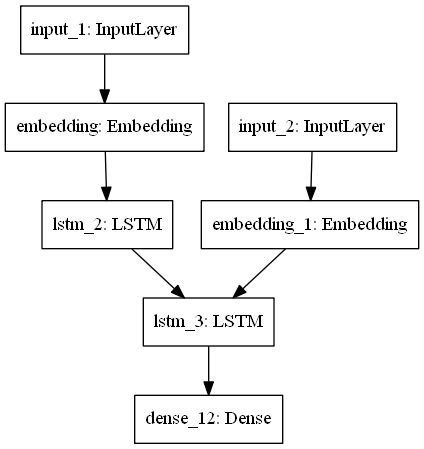

In [122]:
tf.keras.utils.plot_model(
    decoder, show_shapes=False, show_layer_names=True
)

In [123]:
history_deco = decoder.fit(x=[text_train, teacher_train], y=target_train, epochs=20, 
                validation_data=([text_val, teacher_val], target_val))

Epoch 1/20
191/191 [==============================] - 12s 44ms/step - loss: 0.7445 - sparse_categorical_accuracy: 0.5680 - val_loss: 0.6303 - val_sparse_categorical_accuracy: 0.6835
Epoch 2/20
191/191 [==============================] - 7s 39ms/step - loss: 0.5508 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.5280 - val_sparse_categorical_accuracy: 0.7485
Epoch 3/20
191/191 [==============================] - 8s 40ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.7706 - val_loss: 0.5245 - val_sparse_categorical_accuracy: 0.7492
Epoch 4/20
191/191 [==============================] - 8s 40ms/step - loss: 0.4965 - sparse_categorical_accuracy: 0.7744 - val_loss: 0.5412 - val_sparse_categorical_accuracy: 0.7485
Epoch 5/20
191/191 [==============================] - 8s 41ms/step - loss: 0.4848 - sparse_categorical_accuracy: 0.7816 - val_loss: 0.5146 - val_sparse_categorical_accuracy: 0.7557
Epoch 6/20
191/191 [==============================] - 8s 40ms/step - loss: 0.4793 - sparse_cat

In [124]:
history_deco.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

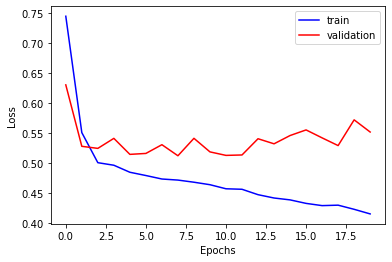

In [125]:
plt.plot(history_deco.history["loss"], color="b", label='train')
plt.plot(history_deco.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

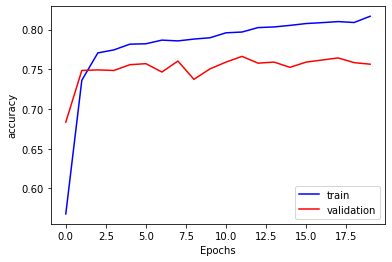

In [126]:
plt.plot(history_deco.history['sparse_categorical_accuracy'], color="b", label='train',)
plt.plot(history_deco.history['val_sparse_categorical_accuracy'], color="r", label='validation')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [127]:
decoder.save("encoder-decoder.h5")
json.dump(decoder.history.history, open("encoder-decoder.json", 'w'))

encoder_decoder = json.load(open("encoder-decoder.json", 'r'))

In [128]:
enc_input = target_val
#classic encoder input

dec_input = tf.ones(shape=(len(target_val),1))
# the first decoder input is the special token 0

enc_out, state_h_inf, state_c_inf = encoder(enc_input)
# we compute once and for all the encoder output and the encoder
# h state and c state

dec_state = [state_h_inf, state_c_inf]
# The encoder h state and c state will serve as initial states for the
# decoder

pred = []  # we'll store the predictions in here

# we loop over the expected length of the target, but actually the loop can run
# for as many steps as we wish, which is the advantage of the encoder decoder
# architecture
for i in range(target_len):
    dec_out, dec_state = decoder_inf([dec_input, dec_state])
    # the decoder state is updated and we get the first prediction probability 
    # vector
    decoded_out = tf.argmax(dec_out, axis=-1)
    # we decode the softmax vector into and index
    pred.append(decoded_out) # update the prediction list
    dec_input = decoded_out # the previous pred will be used as the new input

pred = tf.concat(pred, axis=-1).numpy()
for i in range(10):
    print("pred:", pred[i,:])
    print("true:", target_val[i,:])
    print("\n")

pred: [3]
true: [2]


pred: [3]
true: [3]


pred: [3]
true: [2]


pred: [3]
true: [2]


pred: [3]
true: [3]


pred: [3]
true: [2]


pred: [3]
true: [3]


pred: [3]
true: [2]


pred: [3]
true: [3]


pred: [3]
true: [3]




In [129]:
y_sample = tokenizer_target.sequences_to_texts(target_val)[:10]
pred_sample = tokenizer_target.sequences_to_texts(pred)[:10]

for i, j in zip(y_sample,pred_sample):
    print("true:", i)
    print("pred", j)
    print("\n")

true: 0
pred 1


true: 1
pred 1


true: 0
pred 1


true: 0
pred 1


true: 1
pred 1


true: 0
pred 1


true: 1
pred 1


true: 0
pred 1


true: 1
pred 1


true: 1
pred 1




## Attention is All You Need

In [130]:
url_train = "https://raw.githubusercontent.com/huynam1012/Projet_jedha/main/train.csv"
train = pd.read_csv(url_train)
train = train[["text", "target"]]
train["target"] = train["target"].astype(str)
train.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [131]:
# Add a <start> and <end> token 
def begin_end_sentence(sentence):
    sentence = "<start> "+ sentence + " <end>"
    return sentence

In [132]:
# Add <start> and <end> token
train["text"] = train["text"].apply(lambda x: begin_end_sentence(x))
train["target"] = train["target"].apply(lambda x: begin_end_sentence(x))
train.head(5)

,text,target
0,<start> Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all <end>,<start> 1 <end>
1,<start> Forest fire near La Ronge Sask. Canada <end>,<start> 1 <end>
2,<start> All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected <end>,<start> 1 <end>
3,"<start> 13,000 people receive #wildfires evacuation orders in California <end>",<start> 1 <end>
4,<start> Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school <end>,<start> 1 <end>


In [133]:
# Import of each text and target
import en_core_web_md
nlp_text = en_core_web_md.load()
nlp_target = en_core_web_md.load()

In [134]:
# Add <start> & <end> special case
from spacy.symbols import ORTH

start_case = [{ORTH:"<start>"}]
end_case = [{ORTH: "<end>"}]

nlp_text.tokenizer.add_special_case("<start>", start_case)
nlp_text.tokenizer.add_special_case("<end>", end_case)

nlp_target.tokenizer.add_special_case("<start>", start_case)
nlp_target.tokenizer.add_special_case("<end>", end_case)

In [135]:
train["text"].to_list()[0]

'<start> Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all <end>'

In [136]:
text_corpus = " ".join(train["text"].to_list())
target_corpus = " ".join(train["target"].to_list())

In [137]:
text_corpus[0:100]

'<start> Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all <end> <start> Forest f'

In [138]:
nlp_text.max_length = len(text_corpus)
nlp_target.max_length = len(target_corpus)

text_train = nlp_text(text_corpus)
target_train = nlp_target(target_corpus)

In [139]:
# Tokenization of each sentence via spacy 
train["text_tokens"] = train["text"].apply(lambda x: nlp_text.tokenizer(x))
train["target_tokens"] = train["target"].apply(lambda x: nlp_target.tokenizer(x))
train.head(5)

,text,target,text_tokens,target_tokens
0,<start> Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all <end>,<start> 1 <end>,"(<start>, Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all, <end>)","(<start>, 1, <end>)"
1,<start> Forest fire near La Ronge Sask. Canada <end>,<start> 1 <end>,"(<start>, Forest, fire, near, La, Ronge, Sask, ., Canada, <end>)","(<start>, 1, <end>)"
2,<start> All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected <end>,<start> 1 <end>,"(<start>, All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected, <end>)","(<start>, 1, <end>)"
3,"<start> 13,000 people receive #wildfires evacuation orders in California <end>",<start> 1 <end>,"(<start>, 13,000, people, receive, #, wildfires, evacuation, orders, in, California, , <end>)","(<start>, 1, <end>)"
4,<start> Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school <end>,<start> 1 <end>,"(<start>, Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school, , <end>)","(<start>, 1, <end>)"


In [140]:
# Creation of a set() that will take all the unique tokens from our keyword corpus
target_tokens = [token.text for token in target_train]
target_vocabulary_set= set(target_tokens)
target_vocab_size = len(target_vocabulary_set)
print(target_vocab_size)

4


In [141]:
target_tokens[:5]

['<start>', '1', '<end>', '<start>', '1']

In [142]:
[word for word in target_vocabulary_set][:5]

['1', '0', '<end>', '<start>']

In [143]:
text_tokens = [token.text for token in text_train]
text_vocabulary_set= set(text_tokens)
text_vocab_size = len(text_vocabulary_set)
print(text_vocab_size)

26710


In [144]:
# Creation of an id for each token
all_target_tokens = {}
for i,target_token in enumerate(target_vocabulary_set):
    all_target_tokens[target_token] = i+1 # On prend à i+1 pour laisser la valeur 0 pour la création des padded_sequences

all_text_tokens = {}
for i, text_token in enumerate(text_vocabulary_set):
    all_text_tokens[text_token] = i+1

In [145]:
# Creation of functions that will create a vector of indices for each of the token sequences
def target_tokens_to_index(tokens):
    indices = []
    for token in tokens:
        indices.append(all_target_tokens[token.text])
  
    return indices

def text_tokens_to_index(tokens):
    indices = []
    for token in tokens:
        indices.append(all_text_tokens[token.text])
    
    return indices

In [146]:
# Transformation of tokens into indices
train["text_indices"] = train["text_tokens"].apply(lambda x: text_tokens_to_index(x))
train["target_indices"] = train["target_tokens"].apply(lambda x: target_tokens_to_index(x))
train.head(5)

,text,target,text_tokens,target_tokens,text_indices,target_indices
0,<start> Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all <end>,<start> 1 <end>,"(<start>, Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all, <end>)","(<start>, 1, <end>)","[4307, 11818, 12676, 21426, 13661, 2353, 24454, 26219, 4308, 10274, 26325, 14045, 16294, 7049, 25620, 22229]","[4, 1, 3]"
1,<start> Forest fire near La Ronge Sask. Canada <end>,<start> 1 <end>,"(<start>, Forest, fire, near, La, Ronge, Sask, ., Canada, <end>)","(<start>, 1, <end>)","[4307, 6196, 21655, 2105, 16543, 25204, 12277, 21933, 21770, 22229]","[4, 1, 3]"
2,<start> All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected <end>,<start> 1 <end>,"(<start>, All, residents, asked, to, ', shelter, in, place, ', are, being, notified, by, officers, ., No, other, evacuation, or, shelter, in, place, orders, are, expected, <end>)","(<start>, 1, <end>)","[4307, 7190, 1509, 10931, 2935, 14498, 18011, 19256, 14093, 14498, 21426, 5584, 21676, 10743, 23719, 21933, 12859, 26446, 4220, 14069, 18011, 19256, 14093, 16822, 21426, 3514, 22229]","[4, 1, 3]"
3,"<start> 13,000 people receive #wildfires evacuation orders in California <end>",<start> 1 <end>,"(<start>, 13,000, people, receive, #, wildfires, evacuation, orders, in, California, , <end>)","(<start>, 1, <end>)","[4307, 10850, 18575, 4544, 4308, 10535, 4220, 16822, 19256, 8501, 12805, 22229]","[4, 1, 3]"
4,<start> Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school <end>,<start> 1 <end>,"(<start>, Just, got, sent, this, photo, from, Ruby, #, Alaska, as, smoke, from, #, wildfires, pours, into, a, school, , <end>)","(<start>, 1, <end>)","[4307, 22883, 6720, 24347, 26219, 555, 12106, 6210, 4308, 1605, 24037, 26273, 12106, 4308, 10535, 622, 17946, 10364, 14371, 12805, 22229]","[4, 1, 3]"


In [147]:
# Creating a function that will count the maximum length of a sentence
def max_len(lines):
    return max(len(line) for line in lines)

In [148]:
# Application of the function on text and target tokens 
text_max_len = max_len(train["text_indices"].to_list())
target_max_len = max_len(train["target_indices"].to_list())

In [149]:
print(text_max_len)
print(target_max_len)

81
3


In [150]:
# Use of Keras to create token sequences of the same length
padded_text_indices = tf.keras.preprocessing.sequence.pad_sequences(train["text_indices"], maxlen=text_max_len, padding="post")
padded_target_indices = tf.keras.preprocessing.sequence.pad_sequences(train["target_indices"], maxlen=target_max_len, padding="post")

print(padded_text_indices)
print(padded_target_indices)

[[ 4307 11818 12676 ...     0     0     0]
 [ 4307  6196 21655 ...     0     0     0]
 [ 4307  7190  1509 ...     0     0     0]
 ...
 [ 4307 16974 26119 ...     0     0     0]
 [ 4307 20206  1639 ...     0     0     0]
 [ 4307  5964  7024 ...     0     0     0]]
[[4 1 3]
 [4 1 3]
 [4 1 3]
 ...
 [4 1 3]
 [4 1 3]
 [4 1 3]]


In [151]:
# Creation of variables that we will reuse for our models
BATCH_SIZE = 64
TAKE_SIZE = int(0.8*len(train)/BATCH_SIZE)
BUFFER_SIZE = TAKE_SIZE * BATCH_SIZE
steps_per_epoch = TAKE_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = text_vocab_size
vocab_tar_size = target_vocab_size

In [152]:
# Create a tensorflow dataset complet
tf_ds = tf.data.Dataset.from_tensor_slices((padded_text_indices, padded_target_indices))
# Shuffle & Batch
tf_ds = tf_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [153]:
# Train Validation Split
train_data = tf_ds.take(TAKE_SIZE)
val_data = tf_ds.skip(TAKE_SIZE)

In [154]:
input_text, output_text = next(iter(train_data))
print(input_text.numpy().shape)
print(output_text.numpy().shape)

(64, 81)
(64, 3)


In [155]:
# Encode
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [156]:
encoder = Encoder(vocab_inp_size +1, embedding_dim, units, BATCH_SIZE)

# Sample output
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(input_text, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 81, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [157]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # This is done to calculate our "attention" score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # We get 1 on the last axis because we apply the score to self.V
        # The shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [158]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 81, 1)


In [159]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenate == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passing from the concatenated vector to the GRU layer
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [160]:
decoder = Decoder(vocab_tar_size + 1, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5)


In [161]:
sample_decoder_output

<tf.Tensor: shape=(64, 5), dtype=float32, numpy=
array([[-9.96324234e-03,  1.27057526e-02,  5.10069600e-04,
         1.50917312e-02,  1.62083469e-03],
       [-1.03315040e-02,  1.21188425e-02,  7.89092854e-04,
         1.51111931e-02,  1.04839820e-03],
       [-8.49365722e-03,  1.26076378e-02,  7.47433340e-04,
         1.52824968e-02,  2.33889185e-03],
       [-1.04139177e-02,  1.23249730e-02,  3.21208034e-04,
         1.51927499e-02,  1.40437111e-03],
       [-8.70588608e-03,  1.27742933e-02,  6.30964874e-04,
         1.38679435e-02,  2.72932136e-03],
       [-8.71530082e-03,  1.22740902e-02,  1.51066226e-04,
         1.48227736e-02,  2.09891843e-03],
       [-8.29650462e-03,  1.23109296e-02,  2.66390853e-05,
         1.47496313e-02,  3.45280208e-03],
       [-9.01066698e-03,  1.29633304e-02,  9.51982278e-04,
         1.49153778e-02,  1.61468051e-03],
       [-1.05402926e-02,  1.25548514e-02,  9.90349683e-04,
         1.54941920e-02,  6.94898888e-04],
       [-8.75657424e-03,  1.22655

> Loss

In [162]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [163]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [164]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

> Traning

In [165]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([all_target_tokens["<start>"]] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [166]:
import time

EPOCHS = 5
steps_per_epoch = TAKE_SIZE

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_data.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                        batch,
                                                        batch_loss.numpy()))
    
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.0728
Epoch 1 Batch 10 Loss 0.5089
Epoch 1 Batch 20 Loss 0.2710
Epoch 1 Batch 30 Loss 0.2257
Epoch 1 Batch 40 Loss 0.2424
Epoch 1 Batch 50 Loss 0.2365
Epoch 1 Batch 60 Loss 0.2253
Epoch 1 Batch 70 Loss 0.2250
Epoch 1 Batch 80 Loss 0.2379
Epoch 1 Batch 90 Loss 0.2347
Epoch 1 Loss 0.3173
Time taken for 1 epoch 389.5030744075775 sec

Epoch 2 Batch 0 Loss 0.2337
Epoch 2 Batch 10 Loss 0.2390
Epoch 2 Batch 20 Loss 0.2287
Epoch 2 Batch 30 Loss 0.2173
Epoch 2 Batch 40 Loss 0.2318
Epoch 2 Batch 50 Loss 0.2236
Epoch 2 Batch 60 Loss 0.2294
Epoch 2 Batch 70 Loss 0.2306
Epoch 2 Batch 80 Loss 0.2259
Epoch 2 Batch 90 Loss 0.2228
Epoch 2 Loss 0.2304
Time taken for 1 epoch 324.3126947879791 sec

Epoch 3 Batch 0 Loss 0.2300
Epoch 3 Batch 10 Loss 0.2269
Epoch 3 Batch 20 Loss 0.2473
Epoch 3 Batch 30 Loss 0.2230
Epoch 3 Batch 40 Loss 0.2333
Epoch 3 Batch 50 Loss 0.2274
Epoch 3 Batch 60 Loss 0.2235
Epoch 3 Batch 70 Loss 0.2396
Epoch 3 Batch 80 Loss 0.2323
Epoch 3 Batch 90 Loss 0.2253
E

In [167]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [168]:
checkpoint.restore("training_checkpoints/ckpt-2")
encoder_old=checkpoint.encoder
decoder_old=checkpoint.decoder

In [169]:
encoder_old

In [170]:
for example, label in val_data.take(10):
  hidden = [tf.zeros((1, units))]
  input_t = example[0]
  output_label = label[0]
  enc_out, enc_hidden = encoder(tf.expand_dims(input_t, axis=0), hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([all_target_tokens["<start>"]], 0)

  result = ""

  for t in range(padded_text_indices.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()
    corresponding_word = [word for word, id in all_target_tokens.items() if id==predicted_id]
    result += corresponding_word[0] + " "

    if corresponding_word[0] == '<end>':
      break

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  input_sentence = ""
  for token_id in input_t:
    
    corresponding_word = [word for word, id in all_text_tokens.items() if id==token_id]
    input_sentence += corresponding_word[0] + " "
    if corresponding_word[0] == "<end>":
      break

  true_translation = ""
  for token_id in output_label:
    corresponding_word = [word for word, id in all_target_tokens.items() if id==token_id]
    true_translation += corresponding_word[0] + " "
    if corresponding_word[0] == "<end>":
      break 


print("Text sentence: {}".format(input_sentence))
print("True translation: {}".format(true_translation))
print("Model translation: {}".format(result))

Text sentence: <start> Ignition Knock ( Detonation ) Sensor - Senso Standard KS94 http://t.co/dY1erSDcRh http://t.co/m4cPmxmuRK <end> 
True translation: <start> 1 <end> 
Model translation: 0 <end> 


In [171]:
for example, label in val_data.take(10):

  hidden = [tf.zeros((1, units))]
  input_t = example[0]
  output_label = label[0]
  enc_out, enc_hidden = encoder_old(tf.expand_dims(input_t, axis=0), hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([all_target_tokens["<start>"]], 0)

  result = ""

  for t in range(padded_text_indices.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder_old(dec_input,
                                                          dec_hidden,
                                                          enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()
    corresponding_word = [word for word, id in all_target_tokens.items() if id==predicted_id]
    result += corresponding_word[0] + " "

    if corresponding_word[0] == '<end>':
      break

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  input_sentence = ""
  for token_id in input_t:
    
    corresponding_word = [word for word, id in all_text_tokens.items() if id==token_id]
    input_sentence += corresponding_word[0] + " "
    if corresponding_word[0] == "<end>":
      break

  true_translation = ""
  for token_id in output_label:
    corresponding_word = [word for word, id in all_target_tokens.items() if id==token_id]
    true_translation += corresponding_word[0] + " "
    if corresponding_word[0] == "<end>":
      break 


print("Text sentence: {}".format(input_sentence))
print("True translation: {}".format(true_translation))
print("Model translation: {}".format(result))

Text sentence: <start> @yahoocare perhaps you should change you name to yahoo does n't care .   Are you so inundated with complaints that you can not respond to me ? ? <end> 
True translation: <start> 0 <end> 
Model translation: 0 <end> 
